#  Homework 4 - CE263



## Accessing and Reading Data Sets


In [1]:
import d2l
import math
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn, rnn
from mxnet.gluon import data as gdata
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We downloaded the data into the current directory. To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.shape

(146001, 7)

The training data set includes 1,460 examples, 80 features, and 1 label., the test data contains 1,459 examples and 80 features.

In [4]:
print(train_data.shape)
print(test_data.shape)

(146001, 7)
(30000, 6)


In [5]:
train_data.head()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [5]:
all_features.shape

(176001, 5)

## Data Preprocessing
   
1. Calculate distance
2. Az   
3. Whether weekday  
4. Departing hour  

In [199]:
all_features.isnull().sum()

start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
dtype: int64

In [105]:
all_features.iloc[np.where(all_features['start_lng'].isnull())]

,start_lng,start_lat,end_lng,end_lat,datetime
17,NaN,37.787987,-122.433660,37.797357,2012-09-02 20:34:00
20,NaN,37.791730,-122.402497,37.786780,2012-09-11 18:57:00
641,NaN,37.719803,-122.440650,37.760537,2012-09-08 14:37:00
778,NaN,37.755487,-122.418840,37.789890,2012-09-09 18:08:00
808,NaN,37.794403,-122.416993,37.805458,2012-09-01 13:50:00
1135,NaN,37.790533,-122.395433,37.776652,2012-09-02 17:42:00
2039,NaN,37.778718,-122.392608,37.778982,2012-09-09 14:25:00
2214,NaN,37.787468,-122.402285,37.792150,2012-09-05 15:03:00
2469,NaN,37.761498,-122.392595,37.778805,2012-09-04 14:13:00
2586,NaN,37.780115,-122.431565,37.766722,2012-09-06 23:38:00


In [15]:
all_features.iloc[np.where(all_features['end_lat'].isnull())]

,start_lng,start_lat,end_lng,end_lat,datetime
117,-122.418910,37.806830,-122.391045,NaN,2012-09-01 17:49:00
372,-122.386800,37.617432,-122.404762,NaN,2012-09-05 16:37:00
752,-122.391333,37.787375,-122.412818,NaN,2012-09-13 00:10:00
995,-122.450113,37.766675,-122.395563,NaN,2012-09-16 07:24:00
1056,-122.444467,37.804552,-122.405732,NaN,2012-09-07 23:21:00
1428,-122.440108,37.791795,-122.404682,NaN,2012-09-12 05:43:00
1480,-122.382573,37.715393,-122.396292,NaN,2012-09-03 14:37:00
1525,-122.445355,37.802523,-122.413298,NaN,2012-09-14 18:23:00
1777,-122.401987,37.789303,-122.414682,NaN,2012-09-10 22:09:00
1810,-122.395433,37.776652,-122.428623,NaN,2012-09-07 22:09:00


## Missing values could only be droped instead of filling them up

In [6]:
all_features = all_features.dropna()
all_features.isnull().sum()

start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64

### Calculate the distance

In [7]:
def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371*1000  # m
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = earth_radius * c
    return d

In [8]:
distance =  all_features.apply(lambda x: calculate_distance(x['start_lat'],x['start_lng'], x['end_lat'], x['end_lng']),axis = 1, result_type = 'expand')
#distance.rename(columns = {0:'distance'}, inplace = True)
all_features = pd.concat([all_features, distance],axis = 1)

In [9]:
all_features.rename(columns = {0:'distance'}, inplace = True)
all_features.head()

,start_lng,start_lat,end_lng,end_lat,datetime,distance
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,15760.960867
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,2535.404112
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,9753.753494
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,1168.773227
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,1944.774374


## Normalization: not well...

As stated above, we have a wide variety of datatypes. Before we feed it into a deep network we need to perform some amount of processing. Let's start with the numerical features. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$. To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for 'normalizing' the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

In [10]:
all2 = all_features.copy()
mean = all2['distance'].mean()
std = all2['distance'].std()
all2['distance'] = all2['distance'].apply(lambda x: (x - mean) / (std))
# after standardizing the data all means vanish, hence we can set missing values to 0
#all_features = all_features.fillna(0)

In [67]:
all2.head()

,start_lng,start_lat,end_lng,end_lat,datetime,distance
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,-0.092592
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,-0.108825
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,-0.099965
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,-0.110502
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,-0.109550


In [68]:
all2['distance'] = np.log(all2['distance'])

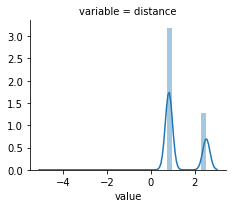

In [69]:
quantitative = [all2.columns[5]]
f = pd.melt(all2, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

### Processing Time

In [11]:
all_features['datetime'] = pd.to_datetime(all_features['datetime'])

In [12]:
all_features['datetime'] = pd.to_datetime(all_features['datetime'])
all_features['hour'] = pd.DatetimeIndex(all_features['datetime']).hour
all_features.head()

,start_lng,start_lat,end_lng,end_lat,datetime,distance,hour
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,15760.960867,0
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,2535.404112,1
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,9753.753494,20
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,1168.773227,23
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,1944.774374,12


In [13]:
all_features['weekday'] = (all_features['datetime'].dt.dayofweek < 5)

In [14]:
all_features.head()

,start_lng,start_lat,end_lng,end_lat,datetime,distance,hour,weekday
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,15760.960867,0,True
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,2535.404112,1,True
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,9753.753494,20,False
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,1168.773227,23,True
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,1944.774374,12,True


### AZ

In [15]:
global time_tuple
global time_tuple_plt
global g
import pyproj
g = pyproj.Geod(ellps='WGS84')
def dir(lat1, lon1, lat2, lon2):
    azN,azS,distance = g.inv(lon1, lat1, lon2, lat2)
    return azN

In [16]:
az =  all_features.apply(lambda x: dir(x['start_lat'],x['start_lng'], x['end_lat'], x['end_lng']),axis = 1, result_type = 'expand')
az.rename(columns = {0:'az'}, inplace = True)
all_features = pd.concat([all_features, az],axis = 1)

In [17]:
all_features.rename(columns = {0:'az'}, inplace = True)
all_features.head()

,start_lng,start_lat,end_lng,end_lat,datetime,distance,hour,weekday,az
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,15760.960867,0,True,-75.031355
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,2535.404112,1,True,175.016926
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,9753.753494,20,False,-97.598453
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,1168.773227,23,True,-44.811513
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,1944.774374,12,True,5.731066


In [18]:
featureMatrix = all_features.drop(columns = ['datetime'])

In [19]:
mean = featureMatrix['distance'].mean()
std = featureMatrix['distance'].std()
featureMatrix['distance'] = featureMatrix['distance'].apply(lambda x: (x - mean) / (std))

In [20]:
n_train = train_data.shape[0] - 1000
train_features = nd.array(featureMatrix.iloc[:n_train, 4:].values)
test_features = nd.array(featureMatrix.iloc[n_train:, 4:].values)
train_labels = nd.array(train_data.dropna().duration.values).reshape((-1, 1))

In [21]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

(145001, 4)
(30000, 4)
(145001, 1)


In [62]:
import matplotlib.pyplot as plt
featureMatrix.iloc[:,4:].corr().style.background_gradient(cmap='coolwarm')

,distance,hour,weekday,az
distance,1,0.0038247,0.00379187,0.0189607
hour,0.0038247,1,0.0805118,-0.0476112
weekday,0.00379187,0.0805118,1,-0.00223182
az,0.0189607,-0.0476112,-0.00223182,1


## Training

To get started we train a linear model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

In [22]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.add(nn.Dense(1))
    net.initialize()
    return net

House prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in this competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

Unlike in the previous sections, the following training functions use the Adam optimization algorithm.  Compared to the previously used mini-batch stochastic gradient descent, the Adam optimization algorithm is relatively less sensitive to learning rates.  This will be covered in further detail later on when we discuss the details on [Optimization Algorithms](../chapter_optimization/index.md) in a separate chapter.

In [23]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)

        mse = np.sqrt(loss(net(train_features), train_labels).mean().asscalar())
        train_ls.append(mse)
        if test_labels is not None:
            mse = np.sqrt(loss(net(test_features), test_labels).mean().asscalar())
            test_ls.append(mse)
    return train_ls, test_ls

## k-Fold Cross-Validation

The k-fold cross-validation was introduced in the section where we discussed how to deal with [“Model Selection, Underfitting and Overfitting"](underfit-overfit.md). We will put this to good use to select the model design and to adjust the hyperparameters. We first need a function that returns the i-th fold of the data in a k-fold cros-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [24]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [25]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train mse: %f, valid mse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection

We pick a rather un-tuned set of hyperparameters and leave it up to the reader to improve the model considerably. Finding a good choice can take quite some time, depending on how many things one wants to optimize over. Within reason the k-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

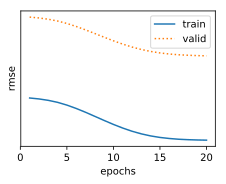

fold 0, train mse: 2327.586182, valid mse: 2521.867676


KeyboardInterrupt: 

In [30]:
k, num_epochs, lr,  weight_decay, batch_size = 5, 20, 0.01, 0.1, 5000
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $K$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

In [28]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train mse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    # reformat it for export to Kaggle
    test_data['duration'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['row_id'], test_data['duration']], axis=1)
    submission.to_csv('submission.csv', index=False)

Let's invoke the model. A good sanity check is to see whether the predictions on the test set resemble those of the k-fold crossvalication process. If they do, it's time to upload them to Kaggle.

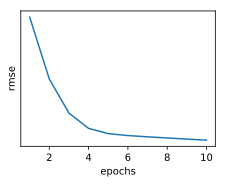

train mse 5536403.500000


In [45]:
# baseline: 630+
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

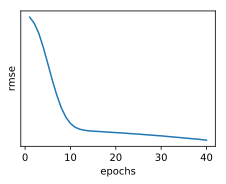

train mse 2359.718750


In [29]:
train_and_pred(train_features, test_features, train_labels, test_data,
               40, lr, weight_decay, batch_size)